# The Ultimate `KumoRFM` Handbook

> *All you need to know or may not know yet!*

The [**`kumoai.experimental.rfm`**](https://kumo-ai.github.io/kumo-sdk/docs/modules/experimental_rfm.html) package provides an implementation of [**`KumoRFM`**](https://kumo.ai/research/kumo_relational_foundation_model.pdf) that aims for

* **low friction** in setting up tables, graphs and predictive queries
* **parity** with the enterprise product

<div align="left">
  <img src="https://kumo-sdk-public.s3.us-west-2.amazonaws.com/rfm-colabs/infrastructure.png" width="500" />
</div>

Most of the actual computation actually happens on the client side, which means that you can quickly test out new ideas *without* going through enterprise and excessive AutoML, *e.g.*:
* *What modifications does my raw data need to fit into the Kumo setting?*
* *Are larger hops beneficial?*
* *Can I improve my graph schema to model the task more precisely?*
* *Does my predictive query compute the labels I expect?*
* *How does my model behave across different anchor times?*

Given reasonable graph size (*i.e.* `<500M` rows), we can expect to answer these questions **within a minute** with `KumoRFM`!

Let's get started:

In [ ]:
!pip install kumoai --pre
!pip install relbench

In [2]:
import kumoai.experimental.rfm as rfm

In [3]:
import os

if not os.environ.get("KUMO_API_KEY"):
    rfm.authenticate()

In [4]:
rfm.init()

INFO:kumoai:Successfully initialized the Kumo SDK against deployment https://kumorfm.ai/api, with log level INFO.


## Graph Schema Definition

`KumoRFM` comes with a type and link inference logic that infers **semantic types**, **primary keys**, **time columns**, and **graph links**, *e.g.*:

* **Primary keys** are inferred based on name matching and fraction of unique values:

  > *Table `USERS` ➡️ `USER_ID` is likely a primary key*

  > **However**: *Table `LOCATION` ➡️ `REGION_ID` is likely **not** a primary key*

* **Time columns** are inferred based on their capability to be parsed to `datetime` format:

  > A column with values such as `"2025-01-01"` is likely a time column

  In cases of multiple time columns, `KumoRFM` will select the column with the latest date, *e.g.*, we choose `CREATE_DATE` over `UPDATE_DATE`

* **Semantic types** are inferred by gathering statistics from a sample:

  > A column likely holds `multicategorical` data if it contains a valid separator (*e.g.*, `;`, `:`, `|` or `\t`) and the number of unique categories when splitting is smaller than the number of unique categories without splitting.

  > An integer column likely holds `categorical` rather than `numerical` data if its unique cardinality is small.

  We support the following semantic types:

| Type | Explanation | Example |
|------|-------------|---------|
| `"numerical"` | Numerical values (*e.g.*, `price`, `age`) | `25`, `3.14`, `-10` |
| `"categorical"` | Discrete categories with limited cardinality | Color: `"red"`, `"blue"`, `"green"` (one cell may only have one category) |
| `"multicategorical"` | Multiple categories in a single cell | `"Action\|Drama\|Comedy"`, `"Action\|Thriller"` |
| `"ID"` | An identifier, *e.g.*, primary keys or foreign keys | `user_id: 123`, `product_id: PRD-8729453` |
| `"text"` | Natural language text | Descriptions |
| `"timestamp"` | Specific point in time | `"2025-07-11"`,  `"2023-02-12 09:47:58`" |
| `"sequence"` | Custom embeddings or sequential data  | `[0.25, -0.75, 0.50, ...]` |

* **Graph links** are inferred based on name matching and value overlap:

  > *`ORDERS.USER_ID` ↔️ `USERS.ID` is likely a valid link*

**Note:** It is hard to guaranteee that type and graph inference work in 100% of all cases, and is expected to be improved constantly. If you see something unexpected, create as many issues as you can!

**Note:** Schema inference is conservative, *e.g.*, we prefer to not infer a primary key rather than to infer a wrong one!

**Note:** Not all semantic types are valid for all underlying data types, *e.g.*, we cannot assign the semantic type `"text"` to a column holding integer values.

Let's see this in action!

In [5]:
from relbench.datasets import get_dataset

db = get_dataset('rel-f1', download=True).get_db(upto_test_timestamp=False)
df_dict = {name: table.df for name, table in db.table_dict.items()}
# Call `from_data(infer_metadata=False)` if you do not want to infer anything!
graph = rfm.LocalGraph.from_data(df_dict, edges=[])

100%|████████████████████████████████████████| 704k/704k [00:00<00:00, 665MB/s]
Unzipping contents of '/root/.cache/relbench/rel-f1/db.zip' to '/root/.cache/relbench/rel-f1/.'


Loading Database object from /root/.cache/relbench/rel-f1/db...
Done in 0.18 seconds.


### 🗂️ Graph Metadata

name,primary_key,time_column
standings,driverStandingsId,date
constructor_standings,constructorStandingsId,date
constructor_results,constructorResultsId,date
constructors,constructorId,-
races,raceId,date
qualifying,qualifyId,date
drivers,driverId,dob
circuits,circuitId,-
results,resultId,date


We can see that `KumoRFM` correctly identified all primary keys and time columns in the `rel-f1` dataset. Correctly specifying primary keys and time columns is the most important part while setting up your data since it defines how tables can be linked and which temporal information is available for a given anchor time.

If you ever need to change/add primary keys or time columns, you can simply do this via:

In [6]:
graph['qualifying'].primary_key = 'qualifyId'
graph['races'].time_column = 'date'

One primary keys are set up, we can start linking tables together:

In [7]:
graph.infer_links();

### 🕸️ Graph Links (FK ↔️ PK)

- `races.circuitId` ↔️ `circuits.circuitId`
- `constructor_results.constructorId` ↔️ `constructors.constructorId`
- `constructor_standings.constructorId` ↔️ `constructors.constructorId`
- `qualifying.constructorId` ↔️ `constructors.constructorId`
- `results.constructorId` ↔️ `constructors.constructorId`
- `qualifying.driverId` ↔️ `drivers.driverId`
- `results.driverId` ↔️ `drivers.driverId`
- `standings.driverId` ↔️ `drivers.driverId`
- `constructor_results.raceId` ↔️ `races.raceId`
- `constructor_standings.raceId` ↔️ `races.raceId`
- `qualifying.raceId` ↔️ `races.raceId`
- `results.raceId` ↔️ `races.raceId`
- `standings.raceId` ↔️ `races.raceId`

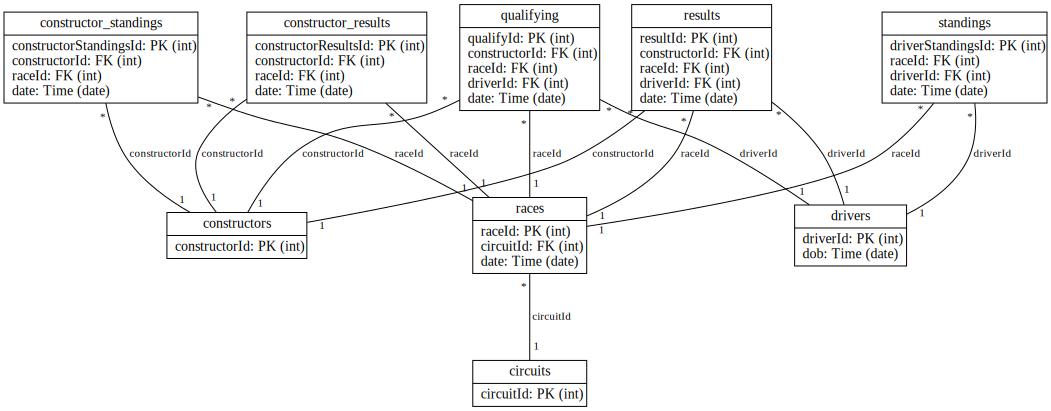

In [8]:
graph.visualize(show_columns=False);

Let's also double check the columns and semantic types in our tables:

In [9]:
display(df_dict['drivers'].head())
graph['drivers'].print_metadata()

,driverId,driverRef,code,forename,surname,dob,nationality
0,0,hamilton,HAM,Lewis,Hamilton,1985-01-07,British
1,1,heidfeld,HEI,Nick,Heidfeld,1977-05-10,German
2,2,rosberg,ROS,Nico,Rosberg,1985-06-27,German
3,3,alonso,ALO,Fernando,Alonso,1981-07-29,Spanish
4,4,kovalainen,KOV,Heikki,Kovalainen,1981-10-19,Finnish


### 🏷️ Metadata of Table `drivers` (857 rows)

name,dtype,stype,is_primary_key,is_time_column
driverId,int,ID,True,False
driverRef,string,text,False,False
code,string,ID,False,False
forename,string,text,False,False
surname,string,text,False,False
dob,date,timestamp,False,True
nationality,string,categorical,False,False


This looks mostly good, but we actually see a lot of duplicated information in what is stored in these columns. For the underlying prediction task, we likely don't need `driverRef`, `code`, `forename` and `surname` all simultaneously. Let's clean this up a bit and only maintain `driverRef`:

In [10]:
del graph['drivers']['code']
del graph['drivers']['forename']
del graph['drivers']['surname']

graph['drivers'].print_metadata()

### 🏷️ Metadata of Table `drivers` (857 rows)

name,dtype,stype,is_primary_key,is_time_column
driverId,int,ID,True,False
driverRef,string,text,False,False
dob,date,timestamp,False,True
nationality,string,categorical,False,False


This looks better. Let's look at another example:

In [12]:
display(df_dict['standings'].head())
graph['standings'].print_metadata()

,driverStandingsId,raceId,driverId,points,position,wins,date
0,0,0,789,0.0,20,0,1950-05-13
1,1,0,640,0.0,18,0,1950-05-13
2,2,0,589,0.0,19,0,1950-05-13
3,3,0,669,0.0,15,0,1950-05-13
4,4,0,661,0.0,22,0,1950-05-13


### 🏷️ Metadata of Table `standings` (34,124 rows)

name,dtype,stype,is_primary_key,is_time_column
driverStandingsId,int,ID,True,False
raceId,int,ID,False,False
driverId,int,ID,False,False
points,float,categorical,False,False
position,int,numerical,False,False
wins,int,categorical,False,False
date,date,timestamp,False,True


This looks alright as well. One could argue that `wins` and `points` should actually be of type `numerical` but are inferred as `categorical` due to their low cardinality. Let's change this:

In [13]:
graph['standings']['wins'].stype = 'numerical'
graph['standings']['points'].stype = 'numerical'
graph['standings'].print_metadata()

### 🏷️ Metadata of Table `standings` (34,124 rows)

name,dtype,stype,is_primary_key,is_time_column
driverStandingsId,int,ID,True,False
raceId,int,ID,False,False
driverId,int,ID,False,False
points,float,numerical,False,False
position,int,numerical,False,False
wins,int,numerical,False,False
date,date,timestamp,False,True


You may note that it is always good to double-check the underlying data and inference logic. **Ensuring to operate on correctly defined data is the most important step in the whole Kumo pipeline!**

The real beauty of the in-memory mode of `KumoRFM` is that we are not bounded by a pre-determined data layout. We can simply change our graph as we like, and see its impact a few seconds later. `KumoRFM` lets you iterate fast, and thus can be both seen as **(1)** an exceptional playground to test out ideas and **(2)** having a training-free prediction workflow.

For example, let's just remove `constructor` and `circuit` tables and see how the model behaves:

In [14]:
del graph['constructors']
del graph['constructor_standings']
del graph['constructor_results']
del graph['circuits']

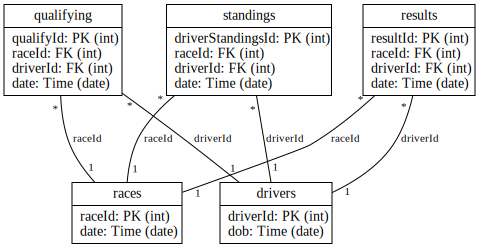

In [15]:
graph.visualize(show_columns=False);

Furthermore, we could simply merge `results` and `standings` tables into a single table since they have a 1-to-1 mapping:

In [16]:
import pandas as pd

results = pd.merge(
    df_dict['results'],
    df_dict['standings'],
    on=['raceId', 'driverId'],
    how='left',
)

## Predictive Queries

Once we are satisfied with our graph, we can initialize our model operating on this graph:

In [ ]:
model = rfm.KumoRFM(graph)

**Note:** It is always good to double-check the logs. Look out for expected timestamp information and graph sizes!

We are now ready to write **predictive queries**:

`KumoRFM` aims for parity with PQL in Kumo enterprise, but ...

* `PREDICT <TARGET> FOR EACH <ENTITY>` needs to be replaced by `PREDICT <TARGET> FOR <ENTITY> IN (<ID>)`: `KumoRFM` is not a batch processor, we make predictions for individual entities!
* The following PQ features are not supported *(yet)*:
  * 2-hop target filters, *e.g.*, `LIST_DISTINCT(orders.item_id WHERE items.category = "...", 0, 7)`
  * 1-hop static targets, *e.g.*, `PREDICT customer_info.AGE FOR customer.ID`
  * Static llink prediction
  * Forecasting
  * Multi-label classification

Let's predict whether a driver will qualify in the top-3 for a race within the next 30 days:

In [18]:
query = ("PREDICT COUNT(qualifying.* WHERE qualifying.position <= 3, 0, 30, days)>0 "
         "FOR drivers.driverId IN ({indices})")

`KumoRFM` allows us to inspect the resulting training table for a given `anchor_time`:

In [19]:
train_table = model.get_train_table(
    query.format(indices='0, 1'),  # Dummy values.
    size=1000,
    anchor_time=pd.Timestamp('2013-03-16'),
)
display(train_table)
display(train_table['TARGET'].value_counts())

,ENTITY,ANCHOR_TIMESTAMP,TARGET
0,61,2013-03-16,False
1,219,2013-03-16,False
2,462,2013-03-16,False
3,354,2013-03-16,False
4,639,2013-03-16,False
...,...,...,...
852,141,2013-03-16,False
853,706,2013-03-16,False
854,548,2013-03-16,False
855,609,2013-03-16,False


,count
TARGET,
False,851
True,6


Oh, it looks like something went wrong. We unexpectedly see very skewed label distribution, and the training table actually contains data for a total of 857 drivers.

It looks like our predictive query is a little ill-defined. We need to filter by **active drivers**, *i.e.* we want to only consider drivers that *can* actually qualify. As such, a better way to write this query is via `MIN` aggregation, which will automatically drop any entity without any event within its time window (alternatively, we can achieve the same via the `ASSUMING` clause):

In [20]:
query = ("PREDICT MIN(qualifying.position, 0, 30, days)<=3 "
         "FOR drivers.driverId IN ({indices})")

In [21]:
train_table = model.get_train_table(
    query.format(indices='0, 1'),  # Dummy values.
    size=1000,
    anchor_time=pd.Timestamp('2013-03-16'),
)
display(train_table)
display(train_table['TARGET'].value_counts())

,ENTITY,ANCHOR_TIMESTAMP,TARGET
0,822,2013-03-16,False
1,812,2013-03-16,False
2,7,2013-03-16,True
3,2,2013-03-16,False
4,0,2013-03-16,True
5,12,2013-03-16,True
6,814,2013-03-16,False
7,817,2013-03-16,False
8,3,2013-03-16,True
9,153,2013-03-16,False


,count
TARGET,
False,16
True,6


This looks better! Now let's make an actual prediction. Let's look up valid drivers from the `qualifying` table:

In [ ]:
indices = df_dict['qualifying'].sort_values('date', ascending=False)['driverId'].iloc[:20]

result = model.predict(
    query.format(indices=', '.join(str(i) for i in indices)),
)
display(result)

Yeah, we got a prediction, but there is also a warning. The warning tells us that `KumoRFM` by default could only found 262 in-context examples, which is far less than it expected (1000). Such situation can naturally arise in `KumoRFM` due to the way online Predictive Query works:

1. We sample a set of entities for a given timestamp
1. We compute their respective labels
1. We drop any entities with invalid labels (*e.g.*, inactive drivers)
1. We repeat this process until we have found 1000 labels or we have reached 20 iterations

Since we have a strict entity filter here (due to the `MIN` aggregation type), 20 iterations of PQ only yield us 262 labels. In these cases, we can tell `KumoRFM` to increase its search window via the **`max_pq_iterations`** option:

In [ ]:
result = model.predict(
    query.format(indices=', '.join(str(i) for i in indices)),
    max_pq_iterations=200,
)
display(result)

This looks better. We have now successfully found 1000 in-context examples.

There exists a few **other options** we can tune as part of `KumoRFM`:

* **`run_mode`**: Defines the trade-off between runtime and model performance (`"fast"`, `"normal"`, `"best"`). By default, this is set to `run_mode="fast"`. Increasing the `run_mode` will gather **(1)** more in-context examples and **(2)** use a "more expensive" model variant.

| `run_mode` | #in-context examples |
| - | - |
| `"fast"` | 1,000 |
| `"normal"` | 5,000 |
| `"best"` | 10,000 |

In [ ]:
result = model.predict(
    query.format(indices=', '.join(str(i) for i in indices)),
    max_pq_iterations=200,
    run_mode="best",
)
display(result)

* **`anchor_time`**: By default, `KumoRFM` will make a prediction for **the latest timestamp** in your data. You can customize this by explicitely specifying at which time you want to make a prediction. If this anchor timestamp is in the past, no future data will be used to derive a prediction:

<div align="left">
  <img src="https://kumo-sdk-public.s3.us-west-2.amazonaws.com/rfm-colabs/predict_time.png" width="600" />
</div>

In [ ]:
model.predict(
    query.format(indices=', '.join(str(i) for i in indices)),
    max_pq_iterations=200,
    run_mode="best",
    anchor_time=pd.Timestamp('2025-01-01'),
)

The warning tells us that the `anchor_time` is too far in the future, which will decrease model performance dramatically (since we are basically lacking 2 years of data here). Let's use a better `anchor_time`:

In [ ]:
result = model.predict(
    query.format(indices=', '.join(str(i) for i in indices)),
    max_pq_iterations=200,
    run_mode="best",
    anchor_time=pd.Timestamp('2023-03-16'),
)
display(result)

* **`num_neighbors`**: Often times, it is desired to have more fine-grained control over how subgraphs are formed. For example, we can decrease the number of neighbors to be sampled in each hop to combat oversmoothing, or increase the number of neighbors to be sampled in each hop to be able to look at a larger time window.

In [ ]:
result = model.predict(
    query.format(indices=', '.join(str(i) for i in indices)),
    max_pq_iterations=200,
    run_mode="best",
    anchor_time=pd.Timestamp('2023-03-16'),
    num_neighbors=[8, 8],
)
display(result)

Finally, we can evaluate how our model behaves *w.r.t.* metrics. For this, `KumoRFM` provides the `evaluate` function, which evaluates on a historical snapshot for which ground-truth labels are available:

<div align="left">
  <img src="https://kumo-sdk-public.s3.us-west-2.amazonaws.com/rfm-colabs/evaluate_time.png" width="700" />
</div>

In [ ]:
metrics = model.evaluate(
    query.format(indices=', '.join(str(i) for i in indices)),
    max_pq_iterations=200,
    run_mode="best",
    anchor_time=pd.Timestamp('2023-03-16'),
    num_neighbors=[8, 8],
)
display(metrics)

**A final note on context size:**

Every predictive query returns the size of the context that is send to the server. The context size has a current limit of **30MB**. In most cases, this should be absolutely sufficient (30MB is tons of data for a single prediction!!!)

If a query exceeds this limit, then this happens either because of:
1. Too many context examples ➡️ reduce the `run_mode`
1. Subgraphs are too big ➡️ reduce neighbor sampling parameters
1. Too many tables/too many columns ➡️ reduce the number of tables or the width of tables, *e.g.*, it may not be necessary to send entire posts or comments for ~100k threads over the wire in order to make a single prediction.

## In-depth Evaluation

Often times, it may be required to evaluate `KumoRFM` against a held out training and test set. `KumoRFM` has full support for **custom training tables** via static PQs.

The idea is simple: We attach a context table to the graph which contains the training and test entities, their timestamps, and training labels. For the test entities, we **keep their labels blank** and ask `KumoRFM` to infer them.
With this scheme, we can support any classification or regressions task by interpreting them as **missing value imputation**.

For `rel-bench`, we can do this by concatenating the task-specific training tables across the different splits, but ensure that we mask out all final test labels to prevent leakage.

In [33]:
from relbench.tasks import get_task

task = get_task('rel-f1', 'driver-top3', download=True)

100%|█████████████████████████████████████| 10.3k/10.3k [00:00<00:00, 9.08MB/s]
Unzipping contents of '/root/.cache/relbench/rel-f1/tasks/driver-top3.zip' to '/root/.cache/relbench/rel-f1/tasks/.'


In [35]:
# Concatenate training labels into a single `pd.DataFrame`:
context_dfs = []
for split in ['test', 'val', 'train']:
    df = task.get_table(split, mask_input_cols=False).df
    df = df.drop(columns='index', errors='ignore')
    df[task.target_col] = df[task.target_col].astype('Int64')
    if split == 'test':
        df[task.target_col] = None  # Do not leak test labels.
    context_dfs.append(df)
context_df = pd.concat(context_dfs, axis=0, ignore_index=True).reset_index()

# Assign this `pd.DataFrame` to a table in the graph:
context_table = rfm.LocalTable(
    context_df,
    name='context',
    primary_key='index',
    time_column=task.time_col,
)
graph.add_table(context_table)
graph.link(context_table.name, task.entity_col, task.entity_table)

context_table.print_metadata()

### 🏷️ Metadata of Table `context` (2,667 rows)

name,dtype,stype,is_primary_key,is_time_column
index,int,ID,True,False
date,date,timestamp,False,True
driverId,int,ID,False,False
qualifying,int,categorical,False,False


Note that we have added a **primary key** `index` to the context table - a unique identifier to be able to reference any row within that table.
This is needed to be able to later predict for individual rows within that table.

We are now ready to evaluate `KumoRFM` on the `driver-top3` task:

In [ ]:
model = rfm.KumoRFM(graph)

Our predictive query now simply performs missing value imputation for the target column in the context table. In order to cast this into a binary classification problem, we explicitely add a condition to the target clause (*i.e.* `target_col = 1`):

In [38]:
query = (f"PREDICT context.{task.target_col} = 1 "
         f"FOR context.index IN ({{indices}})")

In [ ]:
import tqdm
import numpy as np

batch_size = 1000
max_test_steps = 20

ys_pred = []
test_df = task.get_table('test', mask_input_cols=False).df
steps = list(range(0, len(test_df), batch_size))[:max_test_steps]
for i, step in enumerate(tqdm.tqdm(steps)):
    indices = range(step, min(step + batch_size, len(test_df)))
    _query = query.format(indices=', '.join(str(i) for i in indices))
    df = model.predict(
        _query,
        run_mode='best',  # Trades runtime in favor of better model performance.
        anchor_time='entity',  # Use context table time as anchor time.
        num_neighbors=[1, 8, 8],  # Need to increase by 1.
        verbose=i == 0,  # Prevent excessive logging.
    )
    ys_pred.append(df['True_PROB'].to_numpy())

y_pred = np.concatenate(ys_pred)

There exists a few things to look out for in the code snippet above:

* The **`anchor_time`** supports two options: **(1)** a `pd.Timestamp(...)` that denotes the absolute time for when we are making a prediction; **(2)** the string `"entity"`, which tells `KumoRFM` to use the timestamp of the entity as its individual anchor timestamp. In this case, we use `anchor_time="entity"` since we want to make sure that we respect the anchor times given by us as part of the context table.
* Since we added an additional context table to the graph, it is good practice to increase the number of hops in our subgraphs from 2 (default) to 3 (since we first need to go from `context` to `drivers`). We can specify this via the **`num_neighbors`** option (`len(num_neighbors) == 3`).
* The **`verbose`** option ensures that we do not log within every iteration.

Finally, we can compute metrics based on the given ground-truth information from the `rel-bench` test set:

In [40]:
from sklearn.metrics import roc_auc_score

y_test = test_df[task.target_col].to_numpy().astype(int)[:len(y_pred)]
print(f'AUROC: {roc_auc_score(y_test, y_pred):.4f}')

AUROC: 0.9086


This setup lets us benchmark any task with an external training and test set without further modifications required.